In [0]:
dataset=0 # [Fashion MNIST, CIFAR10]

In [134]:
import torch
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
print('Done')

Done


In [0]:
 # get x and y axis to quantify HP/LP structure
 def get_axes(size_im):
    f_axis_0=np.arange(size_im)
    f_axis_0[f_axis_0>np.floor(size_im/2)]=np.flip(np.arange(np.ceil(size_im/2)-1)+1)
    f_axis_0=np.fft.fftshift(f_axis_0)
    f_axis_1=np.arange(size_im)
    f_axis_1[f_axis_1>np.floor(size_im/2)]=np.flip(np.arange(np.ceil(size_im/2)-1)+1)
    f_axis_1=np.fft.fftshift(f_axis_1)

    Y,X=np.meshgrid(f_axis_0/size_im,f_axis_1/size_im)
    return Y,X

In [136]:
# Define dataloader for training
data_transform=transforms.Compose([transforms.ToTensor()])
if dataset==0:
    FMNIST_dataset=datasets.FashionMNIST(root='.', train=True,\
                                  transform=data_transform, download=True)
    dataset_loader=torch.utils.data.DataLoader(FMNIST_dataset)
elif dataset==1:
    CIFAR10_dataset=datasets.CIFAR10(root='.', train=True,\
                                  transform=data_transform, download=True)
    dataset_loader=torch.utils.data.DataLoader(CIFAR10_dataset)

print('Defined data loader...')

Defined data loader...


In [137]:
n_classes=10

if dataset==0:
    size_im=28
elif dataset==1:
    size_im=32

h=np.hamming(size_im)
h_win=np.outer(h,h)

Y,X=get_axes(size_im)
euc_dist=np.sqrt(X**2+Y**2)

mean_fft=np.zeros((size_im,size_im,n_classes))
n_samples=np.zeros(n_classes)
all_mean_f_response=np.zeros(len(dataset_loader))
class_mean_f_response=np.zeros((int(len(dataset_loader)/n_classes),n_classes))

print('Started loop')
image_processed=0
for X, y in dataset_loader:
    if dataset==0:
        X=np.squeeze(X.numpy())
    elif dataset==1:
        X=np.squeeze(np.mean(X.numpy(),axis=1))

    # GAUSSIAN BLUR X

    # Get fft of input image
    X=X*h_win
    fft_sample=np.abs(np.fft.fft2(X))**2
    mean_fft[:,:,y]+=fft_sample # unnormalized
    fft_sample=np.fft.fftshift(fft_sample/np.sum(fft_sample)) # normalized

    # Get HP/LP histogram
    mean_f_response=np.mean(euc_dist*fft_sample)
    all_mean_f_response[image_processed]=mean_f_response
    class_mean_f_response[int(n_samples[y]),y]=mean_f_response

    n_samples[y]+=1
    image_processed+=1
    if image_processed%10000==0:
        print('Done with '+str(image_processed)+' images\n')

hist,bins=np.histogram(all_mean_f_response,bins=100)

Started loop
Done with 10000 images

Done with 20000 images

Done with 30000 images

Done with 40000 images

Done with 50000 images

Done with 60000 images



[6000. 6000. 6000. 6000. 6000. 6000. 6000. 6000. 6000. 6000.]


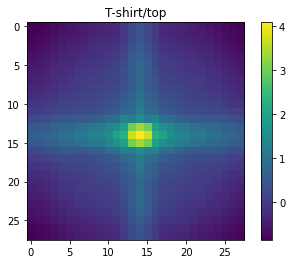

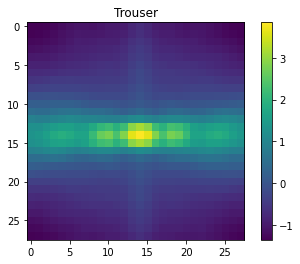

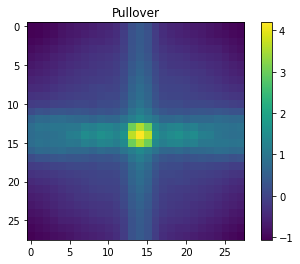

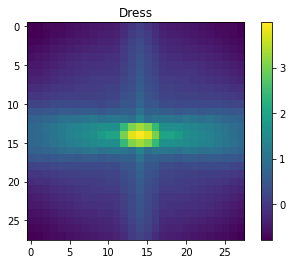

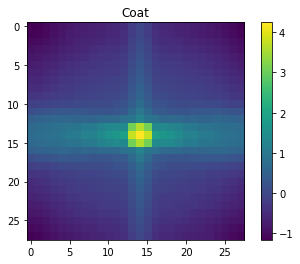

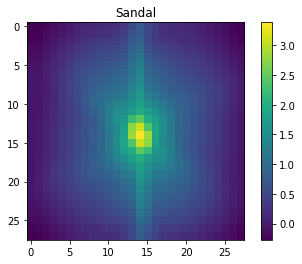

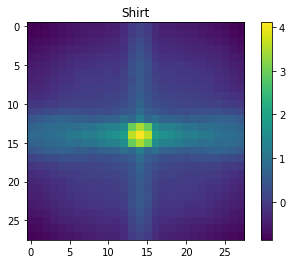

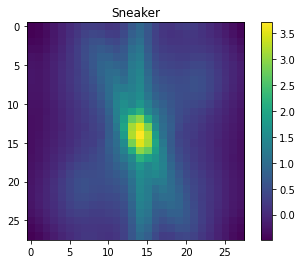

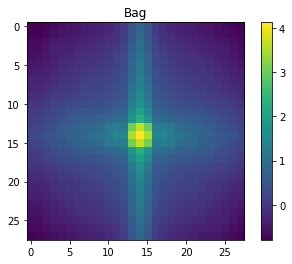

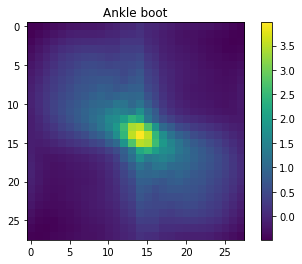

In [138]:
if dataset==0:
    classes=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
elif dataset==1:
    classes=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print(n_samples)

plt.figure(1)
for i in range(n_classes):
    plt.imshow(np.log10(np.fft.fftshift(mean_fft[:,:,i]/n_samples[i])))
    plt.title(classes[i])
    plt.colorbar()
    plt.pause(0.1)

(0.0, 0.00034)

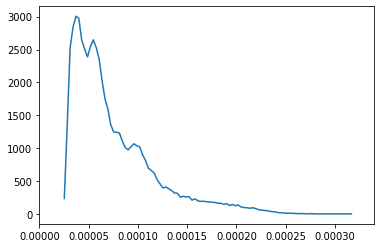

In [146]:
plt.figure(2)
plt.plot(bins[0:-1],hist)
plt.xlim((0,0.00034))

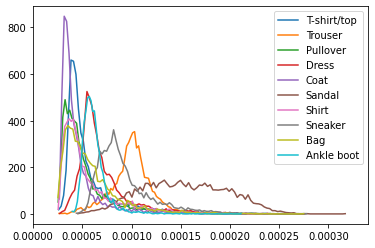

In [145]:
plt.figure(3)
for i in range(n_classes):
    class_hist,class_bins=np.histogram(class_mean_f_response[:,i],bins=100)
    plt.plot(class_bins[0:-1],class_hist,label=classes[i])
    plt.xlim((0,0.00034))
plt.legend()